# Likelihood MP2RAGE
We use the relative likelihood to determine the value of T1.

In [1]:
import os
import json
import nibabel as nib
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.metrics import mean_squared_error
import t1_mapping

# Change plot style
plt.style.use('Solarize_Light2')

# Load data
We load the given data from an example MP2RAGE sequence.

In [2]:
# Load subject
subj = t1_mapping.mp2rage.MP2RAGESubject(
    subject='334264',
    scan='401-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE',
    scan_times=['1010', '3310', '5610']
    )

## Plot T1-weighted image
Now, we plot the T1-weighted image calculated from the gradient echo readouts.

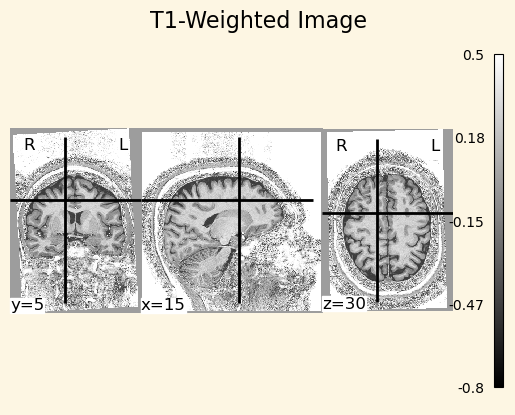

In [3]:
# Plot T1-weighted image
fig, ax = plt.subplots()
plotting.plot_anat(subj.t1w, cut_coords=(15, 5, 30), radiological=True, 
    axes=ax, colorbar=True)
ax.set_title('T1-Weighted Image')
plt.show()

# Load Monte Carlo distribution
Next, we load the results from our Monte Carlo distribution that modeled how to calculate MP2RAGE images if there were some Gaussian noise ($\sigma^2=0.005$) in the gradient echo readouts. This simulation ran for 100 million trials.

In [4]:
# Load NumPy array for counts
counts = np.load(os.path.join(t1_mapping.definitions.SIMULATION_DATA, 'counts_100M_no_nan.npy'))
distr = np.load(os.path.join(t1_mapping.definitions.SIMULATION_DATA, 'distr_100M_no_nan.npy'))

## Calculate ideal MP2RAGE equations

In [5]:
# Range of values for T1
delta_t1 = 0.05
t1_estimate = np.arange(0.05, 5.01, 0.05)
num_points = len(t1_estimate)

# Calculate what values would be produced using these parameters
GRE = t1_mapping.utils.gre_signal(T1=t1_estimate, **subj.eqn_params)

# Calculate what MP2RAGE image would have been
mp2rage1 = t1_mapping.utils.mp2rage_t1w(GRE[0,:], GRE[1,:])
mp2rage2 = t1_mapping.utils.mp2rage_t1w(GRE[0,:], GRE[2,:])

## Plot MP2RAGE equations

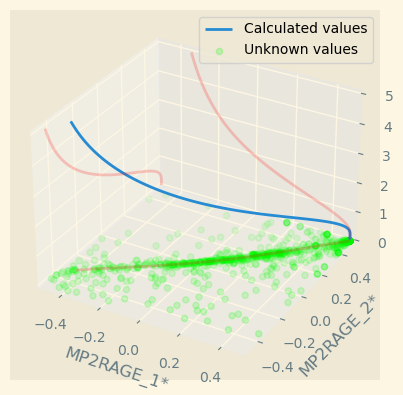

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot curve of known values
ax.plot(mp2rage1, mp2rage2, t1_estimate, label='Calculated values')
ax.set_xlabel('MP2RAGE_1*')
ax.set_ylabel('MP2RAGE_2*')
ax.set_zlabel('T1 (s)')
ax.set(xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0,5))

# Plot values we want to calculate
t1w1 = subj.mp2rage[0]
t1w2 = subj.mp2rage[1]
indx = np.arange(0, len(t1w1.flatten()), 50000)
ax.scatter(t1w1.flatten()[indx], t1w2.flatten()[indx], zdir='z', color=[0,1,0,0.2], label='Unknown values')

# Plot projections
ax.plot(mp2rage1, mp2rage2, zs=0, zdir='z', color=[1,0,0,0.2])
ax.plot(mp2rage1, t1_estimate, zs=-0.5, zdir='x', color=[1,0,0,0.2])
ax.plot(mp2rage2, t1_estimate, zs=0.5, zdir='y', color=[1,0,0,0.2])

ax.legend()

## Calculate likelihoods

Text(0.5, 0.92, '$\\mathcal{L}$ from Uniform')

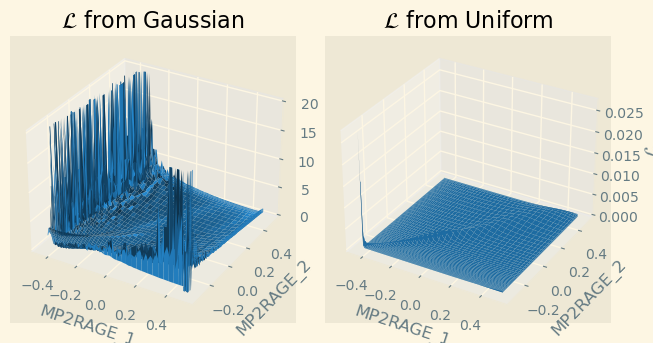

In [32]:
# Likelihood for Gaussian model is given in distr - find max for each
max_L_gauss = np.max(distr, axis=2)

# Likelihood for uniform model
# L_uni = np.full(distr.shape[0:1], 1/(distr.shape[0]*distr.shape[1]))
L_uni = np.sum(counts, axis=2)/np.sum(np.concatenate(counts))
L_uni = np.nan_to_num(L_uni, nan=0)

# Plot likelihoods
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(1, 2, 1, projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, max_L_gauss)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel(r'$\mathcal{L}$')
ax.set_title(r'$\mathcal{L}$ from Gaussian')

ax = fig.add_subplot(1, 2, 2, projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, L_uni)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel(r'$\mathcal{L}$')
ax.set_title(r'$\mathcal{L}$ from Uniform')

## Calculate relative likelihood

/tmp/ipykernel_1069776/3245851932.py:11: RuntimeWarning: invalid value encountered in divide
  alpha = L_uni / (L_uni + max_L_gauss)


Text(0.5, 0.92, '$1 - \\alpha$ Values')

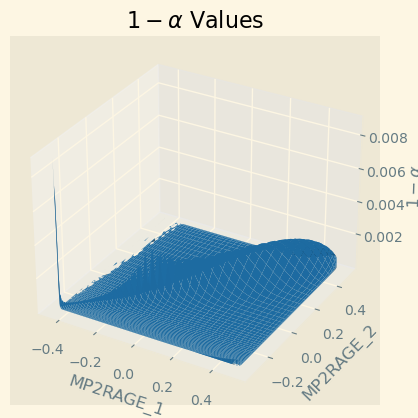

In [40]:
# Find max likelihood
max_L_gauss_ind = np.argmax(distr, axis=2)
max_L_t1_vals = t1_estimate[max_L_gauss_ind]

# Likelihood for uniform model
# L_uni = np.full(distr.shape[0:1], 1/(distr.shape[0]*distr.shape[1]))
L_uni = np.sum(counts, axis=2)/np.sum(np.concatenate(counts))
L_uni = np.nan_to_num(L_uni, nan=0)

# Relative likelihood
alpha = L_uni / (L_uni + max_L_gauss)
# alpha = max_L_gauss/(max_L_gauss + L_uni)

# Plot alpha
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, alpha)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel(r'$1 - \alpha$')
ax.set_title(r'$1 - \alpha$ Values')

## Create LUT

Text(0.5, 0.92, 'LUT')

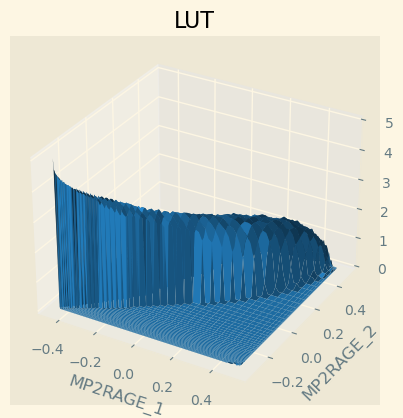

In [13]:
t1_lut = max_L_t1_vals.copy()
T = 0.00025
t1_lut[alpha < T] = 0

# Plot LUT
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, t1_lut)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel('T1')
ax.set_title('LUT')


## Calculate T1 map

In [9]:
t1

NameError: name 't1' is not defined

## Compare to Marques et al.

Text(0.5, 1.0, 'T1 Map (Marques et al.)')

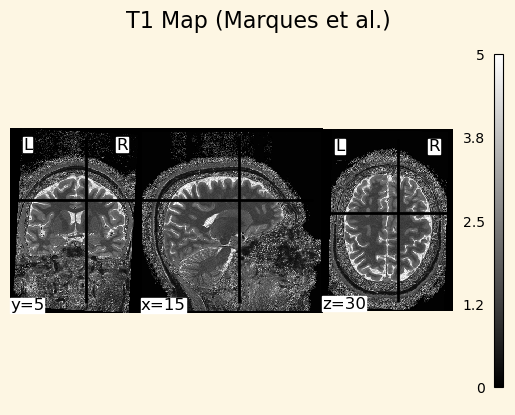

In [ ]:
# Plot T1 map from Marques repo
t1_marques = nib.load('/home/local/VANDERBILT/saundam1/Documents/MP2RAGE-related-scripts/example_t1map2.nii')
t1_marques_data = t1_marques.get_fdata()
fig, ax = plt.subplots()
plotting.plot_img(t1_marques, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True, vmin=0, vmax=5)
ax.set_title('T1 Map (Marques et al.)')

In [ ]:
# Plot difference image
t1_diff = t1_calc - t1_marques.get_fdata()
t1_diff_nifti = nib.nifti1.Nifti1Image(t1_diff, inv1_real.affine)
fig, ax = plt.subplots()
plotting.plot_img(t1_diff_nifti, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True)
ax.set_title('Difference Image')

# Calculate RMSE
t_lin = t1_marques.get_fdata().flatten()
t_calc_lin = t1_calc.flatten()
RMSE = mean_squared_error(t_lin, t_calc_lin, squared=False)
print(f'{RMSE=}')

NameError: name 't1_calc' is not defined

## Save all NIFTIs

In [ ]:
# t1_calc_nifti.to_filename('outputs/example_t1_map.nii')
# t1_marques.to_filename('outputs/example_t1_map_marques.nii')
# t1_diff_nifti.to_filename('outputs/example_t1_map_diff.nii')